In [ ]:
import pandas as pd
import glob
import os
from traffic.core import Traffic
import matplotlib.pyplot as plt
import numpy as np

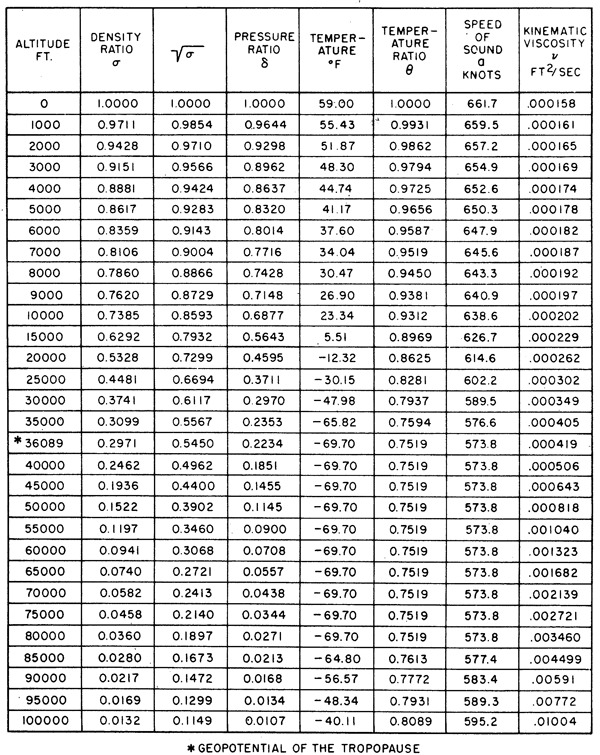

In [ ]:
density_ratio_sqrt = np.array([1, 0.985, 0.971, 0.956, 0.942, 0.928, 0.914, 0.900, 0.886, 0.873, 0.859, 0.793, 0.730, 0.670, 0.612, 0.556, 0.496, 0.440, 0.390])
altitude_ft = np.array([0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000])

### Compute `density altitude`
**Formula:** $\text{Density Altitude} = \text{Pressure Altitude} + \left[120 \times (\text{Outside Air Temperature (OAT)} - \text{Standard Temperature at Altitude})\right]$

Where:
- **Pressure Altitude** is the altitude corrected for atmospheric pressure variations, which can be approximated by the recorded altitude in aviation.
- **Standard Temperature at Altitude** is typically calculated as: $\text{Standard Temperature at Altitude} = 15°C - (2°C \times (\text{Altitude (in thousands of feet)}))$

This assumes that the temperature decreases by 2°C for every 1,000 feet of altitude.

### `airspeed` and `norm_vertical_rate`
`density_ratio_sqrt`: Use `density_altitude` to lookup from `density_ratio_sqrt-vs-altitude` table

`airspeed = groundspeed * density_ratio_sqrt`

`norm_vertical_rate = 1 / density_ratio_sqrt) ^ 2 * vertical_rate`  

Filter for vertical_rate > 500 nt and airspeed > 500 and first order derivative of airspeed > 0.5

In [ ]:
parquet_files = list(sorted(glob.glob(os.path.join("../data_cleaned/", "*.parquet"))))
ias_norm_virt_feature = []
for file in parquet_files:
    print(f"Processing {file=}")
    t = (Traffic.from_file(file)
        # smooth vertical glitches
        .filter()
        # resample at 1s
        .resample('1s')
        # execute all
        .eval()
    )
    for flight in t:
        df = flight.data
        df.sort_values("timestamp", inplace=True)
       
        df['temperature'] = flight.data['temperature'].bfill()
        df['temperature_celsius'] = flight.data['temperature'] - 273.15
        df['standard_temp_at_alt'] = 15 - (2 * (flight.data['altitude'] / 1000))
        df['density_altitude'] = df['altitude'] + 120 * (df['temperature_celsius'] - df['standard_temp_at_alt'])

        df['density_ratio_sqrt'] = np.interp(df.density_altitude, altitude_ft, density_ratio_sqrt)
        df['ias'] = df.groundspeed * df.density_ratio_sqrt
        df['d_ias'] = (df['ias'].shift(-2) - df['ias'].shift(2)) / (df['timestamp'].shift(-2) - df['timestamp'].shift(2)).dt.total_seconds()
        df["norm_vertical_rate"] = ((1 / df.density_ratio_sqrt) ** 2) * (df.vertical_rate)

        #fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8) = plt.subplots(8, 1, figsize=(10, 30))
        #flight.plot_time(ax=ax1, y="altitude")
        #flight.plot_time(ax=ax2, y="groundspeed")
        #flight.plot_time(ax=ax3, y="ias")
        #flight.plot_time(ax=ax4, y="d_ias")
        #flight.plot_time(ax=ax5, y="density_ratio_sqrt")
        #flight.plot_time(ax=ax6, y="vertical_rate")
        #flight.plot_time(ax=ax7, y="norm_vertical_rate")
        #flight.plot_time(ax=ax8, y="density_altitude")
        #plt.title(f"{flight.data.flight_id.unique()[0]}")
        #plt.show()

        df["condition"] = (df.vertical_rate > 500) & (df.ias > 250) & (df.d_ias < 0.5)
        df['group'] = (df['condition'] != df['condition'].shift()).cumsum()
        filtered_df = (
            df[flight.data['condition']]  # Keep only rows where condition is True
            .groupby('group')  # Group by consecutive blocks
            .filter(lambda x: (x['timestamp'].max() - x['timestamp'].min()).total_seconds() >= 5 * 60)  # Duration check
        )

        # fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7, 1, figsize=(10, 30))
        # flight.data = filtered_df
        # flight.plot_time(ax=ax1, y="altitude")
        # flight.plot_time(ax=ax2, y="groundspeed")
        # flight.plot_time(ax=ax3, y="density_ratio_sqrt")
        # flight.plot_time(ax=ax4, y="ias")
        # flight.plot_time(ax=ax5, y="d_ias")
        # flight.plot_time(ax=ax6, y="vertical_rate")
        # flight.plot_time(ax=ax7, y="norm_vertical_rate")
        # plt.title(f"{flight.data.flight_id.unique()[0]}")
        # plt.show()

        ias_norm_virt_feature.append({
            "flight_id": df.flight_id.unique()[0],
            "ias_min": df.ias.min(),
            "ias_max": df.ias.max(),
            "ias_mean": df.ias.mean(),
            "norm_vertical_rate_min": df.norm_vertical_rate.min(),
            "norm_vertical_rate_max": df.norm_vertical_rate.max(),
            "norm_vertical_rate_mean": df.norm_vertical_rate.mean(),
        })

df = pd.DataFrame(ias_norm_virt_feature)
df['flight_id'] = df['flight_id'].astype('int64')
df.to_csv("../data/ias_norm_virt_rate.csv", index=False)

In [ ]:
df = pd.read_csv("../data/ias_norm_virt_rate.csv")
df.describe()